In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from itertools import combinations 
import random
import networkx as nx
import EoN
%matplotlib inline
from concurrent import futures
import concurrent.futures
import seaborn as sns

In [2]:
def create_hq_graph(beta):
        
    is_half_quarantine = True

    G = nx.Graph()
    n_Of_Houses = 25000
    number_of_houses_in_neighborhood = 1000
    mean_of_family_size = 2.52
    std_of_family_size = 1

    if is_half_quarantine:
        house_white_blue_allocator = 0.02 # 0.02 for corona world. 0.93 for normal world
        ratio_of_working_people = 0.21
    else:
        house_white_blue_allocator = 0.93
        ratio_of_working_people = 0.76


    size_of_Houses = []
    for i in range(n_Of_Houses):
        number = round(random.gauss(mean_of_family_size, std_of_family_size))
        while (number < 1):
            number = round(random.gauss(mean_of_family_size, std_of_family_size))

        size_of_Houses.append(number)
        if number == 1:
            G.add_node(len(G))
        else:
            for pair in list(combinations(np.arange(len(G), len(G) + number) , 2)):
                G.add_edge(pair[0], pair[1], weight = 1)
                
                
    # List of Nodes and Houses
    nodes = list(G.nodes())
    df = pd.DataFrame(nodes)
    df.columns = ['Node']

    lst = []
    for i in range(len(size_of_Houses)):
        for j in range(size_of_Houses[i]):
            lst.append(i)

    df['House'] = lst

    house_List = np.arange(0, len(size_of_Houses), 1)

    # WHITE-BLUE
    lst_White = []
    white_blue_likelihood = 0.8
    for house in size_of_Houses:
        is_White = np.random.rand() > house_white_blue_allocator

        for i in range(house):
            if is_White:
                lst_White.append(np.random.rand() < white_blue_likelihood)
            else:
                lst_White.append(np.random.rand() < (1 - white_blue_likelihood))

    df['isWhite'] = lst_White

    # Send people to work
    df['Work'] = -1

    lst_of_jobs = []
    mean_of_job_size = 10
    std_of_job_size = 5
    while np.sum(lst_of_jobs) < df[df['isWhite'] == False].shape[0]:
        job_size = round(random.gauss(mean_of_job_size, std_of_job_size))
        if job_size < 2:
            continue
        lst_of_jobs.append(job_size)
    df_jobs = pd.DataFrame(lst_of_jobs).reset_index()
    df_jobs.columns = ['Job', 'No_of_Ppl']

    l = int(number_of_houses_in_neighborhood * mean_of_family_size / 2)

    mean_of_job_allocator = 0
    std_of_job_allocator = df_jobs.shape[0] / 4


    for node in df[df['isWhite'] == False]['Node'].values:
        list_of_available_jobs = df_jobs[df_jobs['No_of_Ppl'] != 0]['Job'].values
        corresponding_job_for_node = (node * ratio_of_working_people) / mean_of_job_size
        job_allocation = min(list_of_available_jobs, key=lambda x:abs(x - (corresponding_job_for_node + round(random.gauss(mean_of_job_allocator, std_of_job_allocator)))))
        df_jobs.iloc[job_allocation, 1] -= 1
        df.iloc[node, 3] = job_allocation

    # Add edges with  𝛽  for people at same work

    df_workers = df[df['isWhite'] == False]
    for item in df_workers[['Node', 'Work']].groupby('Work'):
        for pair in list(combinations(item[1]['Node'].values , 2)):
            G.add_edge(pair[0], pair[1], weight = beta)
            
            
    if is_half_quarantine:
        ratio_of_service_industry = 0.50
    else:
        ratio_of_service_industry = 0.33
    ratio_of_connections_for_service_industry = 0.05
    servers = df[df['isWhite'] == False].sample(frac = ratio_of_service_industry)['Node'].values

    for server in servers:
        servers_corresponding_node_in_work_neighborhood = int((df.loc[server, 'Work'] * mean_of_job_size) / ratio_of_working_people)
        to_be_served_by_current_server = df.iloc[servers_corresponding_node_in_work_neighborhood - l:servers_corresponding_node_in_work_neighborhood + l, :].sample(frac = ratio_of_connections_for_service_industry)['Node'].values
        for to_be_served in to_be_served_by_current_server:
            if G.has_edge(server, to_be_served) == False:
                G.add_edge(server, to_be_served, weight = beta ** 2)
                
    mean_of_b_3_connections = int(number_of_houses_in_neighborhood * mean_of_family_size *  0.02)
    std_of_b_3_connections = mean_of_b_3_connections / 2
    for node in df['Node'].values:

        number_of_b_3_connections = max(0, round(random.gauss(mean_of_b_3_connections, std_of_b_3_connections)))
        b_3_list = df.iloc[max(0, node-l):node+l, 0].sample(number_of_b_3_connections).values

        for random_person in b_3_list:
            if G.has_edge(node, random_person) == False:
                G.add_edge(node, random_person, weight = beta**3)     
    return G

In [3]:
%%time
def create_wb_graph(beta):
        
    is_half_quarantine = True

    G = nx.Graph()
    n_Of_Houses = 5000
    number_of_houses_in_neighborhood = n_Of_Houses / 25
    mean_of_family_size = 2.52
    std_of_family_size = 1

    if is_half_quarantine:
        house_white_blue_allocator = 0.02 # 0.02 for corona world. 0.93 for normal world
        ratio_of_working_people = 0.21
    else:
        house_white_blue_allocator = 0.93
        ratio_of_working_people = 0.76


    size_of_Houses = []
    for i in range(n_Of_Houses):
        number = round(random.gauss(mean_of_family_size, std_of_family_size))
        while (number < 1):
            number = round(random.gauss(mean_of_family_size, std_of_family_size))

        size_of_Houses.append(number)
        if number == 1:
            G.add_node(len(G))
        else:
            for pair in list(combinations(np.arange(len(G), len(G) + number) , 2)):
                G.add_edge(pair[0], pair[1], weight = 1)
                
                
    # List of Nodes and Houses
    nodes = list(G.nodes())
    df = pd.DataFrame(nodes)
    df.columns = ['Node']

    lst = []
    for i in range(len(size_of_Houses)):
        for j in range(size_of_Houses[i]):
            lst.append(i)

    df['House'] = lst

    house_List = np.arange(0, len(size_of_Houses), 1)

    # WHITE-BLUE
    lst_White = []
    white_blue_likelihood = 0.8
    for house in size_of_Houses:
        is_White = np.random.rand() > house_white_blue_allocator

        for i in range(house):
            if is_White:
                lst_White.append(np.random.rand() < white_blue_likelihood)
            else:
                lst_White.append(np.random.rand() < (1 - white_blue_likelihood))

    df['isWhite'] = lst_White

    # Send people to work
    df['Work'] = -1

    lst_of_jobs = []
    mean_of_job_size = 10
    std_of_job_size = 5
    while np.sum(lst_of_jobs) < df[df['isWhite'] == False].shape[0]:
        job_size = round(random.gauss(mean_of_job_size, std_of_job_size))
        if job_size < 2:
            continue
        lst_of_jobs.append(job_size)
    df_jobs = pd.DataFrame(lst_of_jobs).reset_index()
    df_jobs.columns = ['Job', 'No_of_Ppl']

    l = int(number_of_houses_in_neighborhood * mean_of_family_size / 2)

    mean_of_job_allocator = 0
    std_of_job_allocator = df_jobs.shape[0] / 4


    for node in df[df['isWhite'] == False]['Node'].values:
        list_of_available_jobs = df_jobs[df_jobs['No_of_Ppl'] != 0]['Job'].values
        corresponding_job_for_node = (node * ratio_of_working_people) / mean_of_job_size
        job_allocation = min(list_of_available_jobs, key=lambda x:abs(x - (corresponding_job_for_node + round(random.gauss(mean_of_job_allocator, std_of_job_allocator)))))
        df_jobs.iloc[job_allocation, 1] -= 1
        df.iloc[node, 3] = job_allocation

    # Add edges with  𝛽  for people at same work

    df_workers = df[df['isWhite'] == False]
    for item in df_workers[['Node', 'Work']].groupby('Work'):
        for pair in list(combinations(item[1]['Node'].values , 2)):
            G.add_edge(pair[0], pair[1], weight = beta)
            
            
    if is_half_quarantine:
        ratio_of_service_industry = 0.50
    else:
        ratio_of_service_industry = 0.33
    ratio_of_connections_for_service_industry = 0.05
    servers = df[df['isWhite'] == False].sample(frac = ratio_of_service_industry)['Node'].values

    for server in servers:
        servers_corresponding_node_in_work_neighborhood = int((df.loc[server, 'Work'] * mean_of_job_size) / ratio_of_working_people)
        to_be_served_by_current_server = df.iloc[servers_corresponding_node_in_work_neighborhood - l:servers_corresponding_node_in_work_neighborhood + l, :].sample(frac = ratio_of_connections_for_service_industry)['Node'].values
        for to_be_served in to_be_served_by_current_server:
            if G.has_edge(server, to_be_served) == False:
                G.add_edge(server, to_be_served, weight = beta ** 2)
                
    mean_of_b_3_connections = int(number_of_houses_in_neighborhood * mean_of_family_size *  0.02)
    std_of_b_3_connections = mean_of_b_3_connections / 2
    for node in df['Node'].values:

        number_of_b_3_connections = max(0, round(random.gauss(mean_of_b_3_connections, std_of_b_3_connections)))
        b_3_list = df.iloc[max(0, node-l):node+l, 0].sample(number_of_b_3_connections).values

        for random_person in b_3_list:
            if G.has_edge(node, random_person) == False:
                G.add_edge(node, random_person, weight = beta**3)    
                

    df['Number_of_Friends_so_far'] = 0
    df['Number_of_Friends_defined'] = 0
    mean_of_number_of_friends = 6.5
    std_of_number_of_friends = 3
    lst_friendlist = []
    for node in df['Node'].values:
        number_of_friends = max(0, round(random.gauss(mean_of_number_of_friends, std_of_number_of_friends)))
        df.loc[node, 'Number_of_Friends_defined'] = number_of_friends


    # FRIENDSHIP
    while df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']].shape[0]>1:

        node = df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']]['Node'].sample(1).values[0]
        #friendlist_of_node = ""
        while df.loc[node, 'Number_of_Friends_so_far'] < df.loc[node, 'Number_of_Friends_defined']:
            some_std = max(0, round(random.gauss(0, df.shape[0] / 2 )))
            while df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']].iloc[max(0, node - (l + some_std)): node + (l + some_std)].shape[0] < 1:
                some_std = (some_std + 5)*2
            friendNode = df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']].iloc[max(0, node - (l + some_std)): node + (l + some_std)]['Node'].sample(1).values[0]
            if df.loc[friendNode, 'Number_of_Friends_so_far'] < df.loc[friendNode, 'Number_of_Friends_defined']:
                df.loc[node, 'Number_of_Friends_so_far'] += 1
                df.loc[friendNode, 'Number_of_Friends_so_far'] += 1
                G.add_edge(node, friendNode, weight = beta)
                #friendlist_of_node = friendlist_of_node + (str(friendNode) + ",")         

        # Weak interactions, 10x the number of friends, 10% being beta**2

        nodes_of_weak_interactions = df['Node'].sample(10 * number_of_friends).values
        for weak_interaction_node in nodes_of_weak_interactions:
            if np.random.rand() < 0.1:
                if G.has_edge(node, weak_interaction_node) == False:
                    G.add_edge(node, weak_interaction_node, weight = beta**2)      
            else:
                if G.has_edge(node, weak_interaction_node) == False:
                    G.add_edge(node, weak_interaction_node, weight = beta**3)

    return G

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


In [4]:
# SIR method
def SIR(pair):
    beta = pair[0]
    gamma = pair[1]
    G = create_wb_graph(beta)
    t, S, I ,R = EoN.fast_SIR(G, tau = 1, gamma = gamma, transmission_weight = 'weight', initial_infecteds = int(len(G) / 2), return_full_data = False)
    return [beta, gamma, t[-1], min(S), max(I)]

In [36]:
%%time
main_list = []
list_of_beta= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
list_of_gamma = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]

list_of_beta_gamma_pair = 5 * list(itertools.product(list_of_beta, list_of_gamma))

with concurrent.futures.ProcessPoolExecutor() as executor:
    for returned_object in executor.map(SIR, list_of_beta_gamma_pair):
        main_list.append(returned_object)

df = pd.DataFrame(main_list)
df.columns = ['Beta', 'Gamma', 't', 'min(S)', 'max(I)']

CPU times: user 2.33 s, sys: 776 ms, total: 3.11 s
Wall time: 4h 20min 9s


In [37]:
df.to_csv('WB_beta_gamma_SIR_another_5_iteration.csv')

- Data of Half Quarantine

In [15]:
# df = pd.read_csv('FINAL_beta_gamma_SIR_15_iterations_all_values.csv', index_col = 0)

- Data of World Before Covid-19

In [13]:
#df.to_csv('FINAL_WB_beta_gamma_SIR_10_iterations.csv')
df = pd.read_csv('FINAL_WB_beta_gamma_SIR_10_iterations.csv')

In [14]:
df_grouped = df.groupby(['Beta', 'Gamma']).mean().reset_index().sort_values(by = ['Beta', 'Gamma'])

In [15]:
df_pw = pd.DataFrame()
for beta in df_grouped['Beta'].unique():
    df_pw[beta] = df_grouped[df_grouped['Beta'] == beta]['max(I)'].values
df_pw.index = df_grouped['Gamma'].unique()

Text(0.5, 1, 'World Before Covid-19 Disease Spreading Heatmap for Beta-Gamma Pairs')

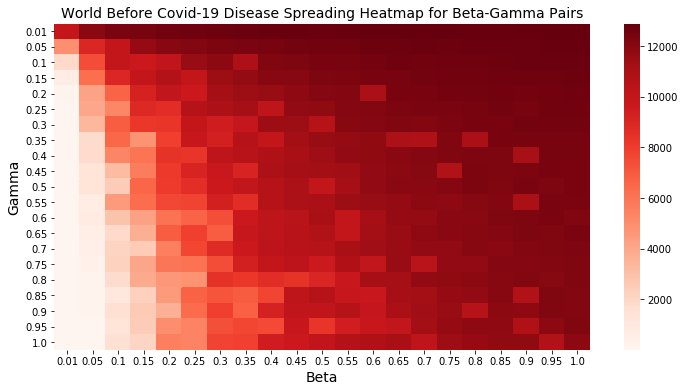

In [17]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(df_pw, cmap="Reds", ax = ax)
ax.set_xlabel('Beta', fontsize = 14)
ax.set_ylabel('Gamma', fontsize = 14)
ax.set_title('World Before Covid-19 Disease Spreading Heatmap for Beta-Gamma Pairs', fontsize = 14)

# Basic SI

In [4]:
# SI method
def SI(null_variable):
    if null_variable == 'HQ':
        G = create_hq_graph(0.5)
    else:
        G = create_wb_graph(0.5)
    t, S, I ,R = EoN.fast_SIR(G, tau = 1, gamma = 0, transmission_weight = 'weight', initial_infecteds = np.random.randint(0, len(G)), return_full_data = False)
    
    return t[-1]

- Half Quarantine Graph

In [5]:
%%time
main_list_HQ = []
null_variable_list = 256 * ['HQ']

with concurrent.futures.ProcessPoolExecutor(max_workers = 64) as executor:
    for returned_object in executor.map(SI, null_variable_list):
        main_list_HQ.append(returned_object)


CPU times: user 292 ms, sys: 268 ms, total: 560 ms
Wall time: 18min 39s


In [11]:
pd.DataFrame(main_list_HQ).to_csv('main_list_HQ.csv')

In [12]:
np.mean(main_list_HQ)

1.3957003163607915

- World Before Covid-19 Graph

In [6]:
%%time
main_list_WB = []
null_variable_list = 256 * ['WB']

with concurrent.futures.ProcessPoolExecutor(max_workers = 64) as executor:
    for returned_object in executor.map(SI, null_variable_list):
        main_list_WB.append(returned_object)

CPU times: user 1.11 s, sys: 700 ms, total: 1.81 s
Wall time: 7h 13min 8s


In [7]:
pd.DataFrame(main_list_WB).to_csv('main_list_WB.csv')

In [13]:
np.mean(main_list_WB)

0.7817641657644708